<a href="https://colab.research.google.com/github/aflita/image-captioning-flickr8k/blob/master/Inception_LSTM_Flickr8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'aflita'
os.environ['KAGGLE_KEY'] = 'cad9302366db38692e6dfc19fee87783'

In [0]:
!rm -rf flickr8k

In [0]:
import tensorflow as tf
import numpy as np
import pickle
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.models import Model

In [3]:
!kaggle datasets download -d shadabhussain/flickr8k

 99% 2.11G/2.13G [00:27<00:00, 71.3MB/s]
100% 2.13G/2.13G [00:27<00:00, 83.8MB/s]


In [0]:
!unzip -q flickr8k.zip -d .

In [0]:
# Read Image Folder
image_folder = '/content/Flickr_Data/Flickr_Data/Images'
# Read Annotation Folder
annotation_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
# Read Training File
train_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# Read Validation File
val_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
# Read Test File
test_file = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

In [0]:
unique_train = open(train_file, 'r').read().splitlines()
unique_val = open(val_file, 'r').read().splitlines()
unique_test = open(test_file, 'r').read().splitlines()
annotations = open(annotation_file,'r').read().splitlines()

In [4]:
# Token
# Store 6k Training Lists
import re

def collect_list(unique_set):
  data = []
  for idx, el in enumerate(annotations):
    # Split Image ID with Captions
    fname, cap = re.split("#[0-9][\t]", el)
    cap = cap.split()
    cap = [w for w in cap if len(w)>1]
    cap = ' '.join(cap)
    cap = '<start> ' + cap + ' <end>'
    cap = cap.lower()
    if fname in unique_set:
      data.append([fname,cap])
  #  else:
  #    continue
  return data

train_set = collect_list(unique_train)
val_set = collect_list(unique_val)
test_set = collect_list(unique_test)

print('Collected Train Sets: %d' %len(train_set))
print('Collected Val Sets: %d' %len(val_set))
print('Collected Test Sets: %d' %len(test_set))
print('\n')
print('Unique Train Sets: %d' %len(unique_train))
print('Unique Val Sets: %d' %len(unique_val))
print('Unique Test Sets: %d' %len(unique_test))

Collected Train Sets: 30000
Collected Val Sets: 5000
Collected Test Sets: 5000


Unique Train Sets: 6000
Unique Val Sets: 1000
Unique Test Sets: 1000


In [5]:
# Baseline Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input

model = tf.keras.applications.InceptionV3(weights='imagenet')

model = tf.keras.Model(inputs = model.input,
                                outputs = model.layers[-2].output)

Using TensorFlow backend.


In [0]:
def preprocess_image(filename, model):
  file = os.path.join(image_folder, filename)
  image = load_img(file, target_size=(299, 299, 3))
  image = img_to_array(image)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)    
  feature = model.predict(image)
  return feature

def extract_feature(unique):
  features = {}
  for i, name in enumerate(unique):
      #file = os.path.join(image_folder, name)
      feature = preprocess_image(file, model)
      features[name] = np.reshape(feature, feature.shape[1])
      #print('>%s' % name)
  print('Features Extracted: %d' %len(features))
  return features

In [0]:
# Optional
# Extract Train Image Features



train_features = extract_feature(unique_train)
val_features = extract_feature(unique_val)

In [0]:
# Save Feature
pickle.dump(train_features, open('train_features.pkl','wb'))
pickle.dump(val_features, open('val_features.pkl','wb'))


In [0]:
# Open Features
train_path_feature = '/content/train_features.pkl'
with open(train_path_feature, 'rb') as ftr:
  train_features = pickle.load(ftr, encoding="bytes")

val_path_feature = '/content/val_features.pkl'
with open(val_path_feature, 'rb') as fvs:
  val_features = pickle.load(fvs, encoding="bytes")

In [12]:
print(train_features['3296150666_aae2f64348.jpg'].shape), print(len(train_features)), print(len(val_features))

(2048,)
6000
1000


(None, None, None)

In [13]:
# Token
train_captions = [train[1] for train in train_set]

num_words = 7370
oov = '<unk>'
filt = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '

tokenizer = Tokenizer(num_words+1, oov_token = oov, filters = filt)
tokenizer.fit_on_texts(train_captions)
word2index = tokenizer.word_index
vocab_size = len(word2index) + 1

print('Vocabulary Size: %d' % vocab_size)
max_length = max(len(d.split()) for d in train_captions)
print('Description Length: %d' % max_length)

Vocabulary Size: 7369
Description Length: 34


In [14]:
# Reverse Index to Word
index2word = dict([(value, key) for (key, value) in word2index.items()])

# Set Padding as Zero
word2index['<pad>'] = 0
index2word[0] = '<pad>'

# Fit Token to Texts
train_seq = tokenizer.texts_to_sequences(train_captions)
train_seq[0]

[2, 43, 4, 88, 172, 7, 117, 53, 390, 12, 397, 4, 28, 4438, 629, 3]

In [0]:
def create_sequence(sequence_name):
  padded_sequences, subsequent_words = [], []

  for seq in sequence_name:
      partial_seqs = []
      next_words = []
      for i in range(1, len(seq)):
        partial_seqs.append(seq[:i])
        next_words.append(seq[i])
      padded_partial_seqs = pad_sequences(partial_seqs, max_length, padding='post')

      next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
      
      #Vectorization
      for i,next_word in enumerate(next_words):
          next_words_1hot[i, next_word] = 1
          
      padded_sequences.append(padded_partial_seqs)
      subsequent_words.append(next_words_1hot)
      
  padded_sequences = np.asarray(padded_sequences)
  subsequent_words = np.asarray(subsequent_words)
  return padded_sequences, subsequent_words

In [0]:
padded_sequences, subsequent_words = create_sequence(train_seq)
vpadded_sequences, vsubsequent_words = create_sequence(val_seq)

print(padded_sequences.shape)
print(subsequent_words.shape)
print(vpadded_sequences.shape)
print(vsubsequent_words.shape)

In [15]:
padded_sequences, subsequent_words = [], []

for seq in train_seq:
    partial_seqs = []
    next_words = []
    for i in range(1, len(seq)):
      partial_seqs.append(seq[:i])
      next_words.append(seq[i])
    padded_partial_seqs = pad_sequences(partial_seqs, max_length, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


In [0]:
def create_capnext(num_of_images, padded_sequences, subsequent_words, captions, next_words):
  captions = np.zeros([0, max_length])
  next_words = np.zeros([0, vocab_size])

  for i in range(num_of_images):
    captions = np.concatenate([captions, padded_sequences[i]])
    next_words = np.concatenate([next_words, subsequent_words[i]])
    print(i)
  
  np.save(captions+'npy', captions)
  np.save(next_words+'.npy', next_words)
  return captions, next_words

In [16]:
num_of_images = 6000

captions = np.zeros([0, max_length])
next_words = np.zeros([0, vocab_size])

print(captions.shape), print(next_words.shape)

(0, 34)
(0, 7369)


(None, None)

In [0]:
# Store Captions and Next Words to Disk

for i in range(num_of_images):
  captions = np.concatenate([captions, padded_sequences[i]])
  next_words = np.concatenate([next_words, subsequent_words[i]])
  print(i)
  
np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

In [19]:
print(captions.shape)
print(next_words.shape)

(61800, 34)
(61800, 7369)


In [20]:
imgs = []

for i in range(len(train_set)):
    if train_set[i][0] in train_features.keys():
      imgs.append(list(train_features[train_set[i][0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(30000, 2048)


In [21]:
images = []

for ix in range(6000):#num_of_images
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(61800, 2048)


In [0]:
#image_names = []

#for ix in range(6000): #num_of_images
#    for iy in range(padded_sequences[ix].shape[0]):
#        image_names.append(train_set[i][0])
        
#image_names = np.asarray(image_names)

#np.save("image_names.npy", image_names)

#print(len(image_names))

61800


In [0]:
# Token
val_captions = [val[1] for val in val_set]

tokenizer.fit_on_texts(val_captions)

#print('Vocabulary Size: %d' % vocab_size)
#max_length = max(len(d.split()) for d in train_captions)
#print('Description Length: %d' % max_length)

In [23]:
# Fit Token to Texts
val_seq = tokenizer.texts_to_sequences(val_captions)
val_seq[0]

[2, 43, 8, 18, 17, 23, 1000, 276, 4, 196, 186, 3]

In [31]:
vcaptions = np.zeros([0, max_length])
vnext_words = np.zeros([0, vocab_size])

#print(vcaptions.shape), print(vnext_words.shape)

(0, 34)
(0, 7369)


(None, None)

In [0]:
# Store Captions and Next Words to Disk

for i in range(1000):
  vcaptions = np.concatenate([vcaptions, vpadded_sequences[i]])
  vnext_words = np.concatenate([vnext_words, vsubsequent_words[i]])
  print(i)
  
np.save("vcaptions.npy", vcaptions)
np.save("vnext_words.npy", vnext_words)

print(vcaptions.shape)
print(vnext_words.shape)

In [33]:
imgs = []

for i in range(len(val_set)):
    if val_set[i][0] in val_features.keys():
      imgs.append(list(val_features[val_set[i][0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(5000, 2048)


In [34]:
images = []

for ix in range(1000):#num_of_images
    for iy in range(vpadded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("vimages.npy", images)

print(images.shape)

(10560, 2048)


Model

In [36]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")
images = np.load("images.npy")

print(captions.shape)
print(next_words.shape)
print(images.shape)

(61800, 34)
(61800, 7369)
(61800, 2048)


In [37]:
vcaptions = np.load("vcaptions.npy")
vnext_words = np.load("vnext_words.npy")
vimages = np.load("vimages.npy")
print(vcaptions.shape)
print(vnext_words.shape)
print(vimages.shape)

(10560, 34)
(10560, 7369)
(10560, 2048)


In [0]:
embedding_size = 128
max_len = max_length

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate


image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

#image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

#language_model.summary()



In [0]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
#model.summary()

In [0]:
from keras.callbacks import ModelCheckpoint

# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [44]:
hist = model.fit([images, captions], next_words, batch_size=309, epochs=200, callbacks=[checkpoint], validation_data=([vimages, vcaptions], vnext_words))

Train on 61800 samples, validate on 10560 samples
Epoch 1/200
61800/61800 [==============================] - 97s 2ms/step - loss: 5.6392 - accuracy: 0.1049 - val_loss: 5.7010 - val_accuracy: 0.1045

Epoch 00001: val_loss improved from inf to 5.70096, saving model to model-ep001-loss5.639-val_loss5.701.h5
Epoch 2/200
61800/61800 [==============================] - 97s 2ms/step - loss: 5.6785 - accuracy: 0.0973 - val_loss: 5.7844 - val_accuracy: 0.0947

Epoch 00002: val_loss did not improve from 5.70096
Epoch 3/200
61800/61800 [==============================] - 96s 2ms/step - loss: 5.6622 - accuracy: 0.0971 - val_loss: 5.7732 - val_accuracy: 0.0947

Epoch 00003: val_loss did not improve from 5.70096
Epoch 4/200
61800/61800 [==============================] - 96s 2ms/step - loss: 5.6118 - accuracy: 0.1013 - val_loss: 5.7049 - val_accuracy: 0.1051

Epoch 00004: val_loss did not improve from 5.70096
Epoch 5/200
61800/61800 [==============================] - 95s 2ms/step - loss: 5.5066 - accur

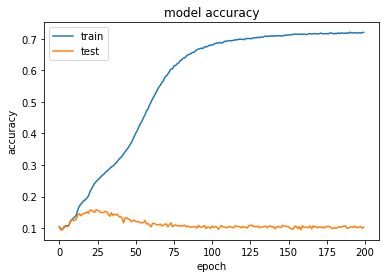

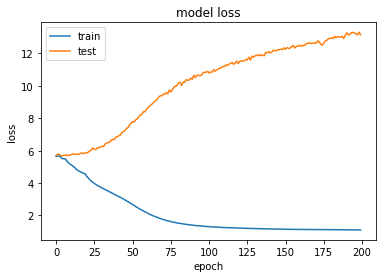

In [46]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save_weights("model_200.h5")

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!cp -r /content/next_words.npy '/content/gdrive/My Drive/'
!cp -r /content/captions.npy '/content/gdrive/My Drive/'

In [0]:
!cp -r /content/train_features.pkl '/content/gdrive/My Drive/'

Predict

In [0]:
inception = tf.keras.applications.InceptionV3(weights='imagenet')
inception = tf.keras.Model(inputs = inception.input,
                                outputs = inception.layers[-2].output)

In [0]:
def preprocess_image(file):
  file = os.path.join(image_folder, file)
  image = load_img(file, target_size=(299, 299, 3))
  image = img_to_array(image)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)    
  return image

def extract_feature(model, image):
  #features = {}
  #for i, name in enumerate(unique):
  #file = os.path.join(image_folder, name)
  feature = preprocess_image(image)
  feature = model.predict(image)
  features[name] = np.reshape(feature, feature.shape[1])
  #print('>%s' % name)
  #print('Features Extracted: %d' %len(features))
  return features

In [0]:
test_img = os.path.join(image_folder,unique_test[0])

In [0]:
#test = extract_feature(inception,test_img)
image = preprocess_image(test_img)
feature = inception.predict(image)
feature = np.reshape(feature, feature.shape[1])

In [97]:
feature.shape

(2048,)

In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2index[i] for i in start_word]
        par_caps = pad_sequences([par_caps], maxlen=max_length, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = index2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(feature)

In [0]:
from IPython.display import Image, display

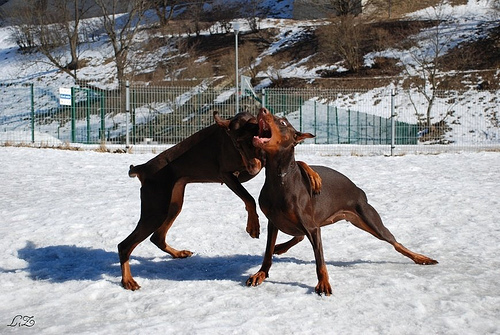

man in red shorts standing on rocks by stream


In [102]:
z = Image(filename=test_img)
display(z)

print(Argmax_Search)

In [0]:
#######################################################################################

In [0]:
######################################################################################

In [0]:
########################################################################################

In [0]:
########################################################################################

In [0]:
#########################################################################################